<a href="https://colab.research.google.com/github/nourlbd/Detection_Fraude/blob/master/Projet_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [97]:
import pandas as pd

path_data = "./gdrive/MyDrive/projets/credit_card.csv"

df = pd.read_csv(path_data, sep=",")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, plot_confusion_matrix


# **Visualisation**

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


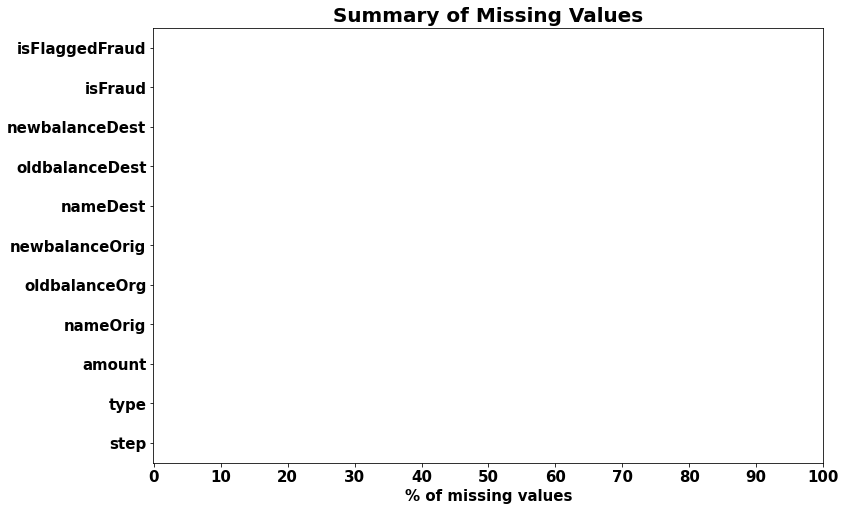

In [100]:
(df.isna().sum() / df.shape[0] * 100)\
    .sort_values()\
    .plot(kind='barh', figsize=(12,8))
plt.xticks(np.arange(0,110,10), fontsize=15, fontweight='bold')
plt.xlabel("% of missing values", fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title("Summary of Missing Values", fontsize=20, fontweight='bold')
plt.show()

In [101]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



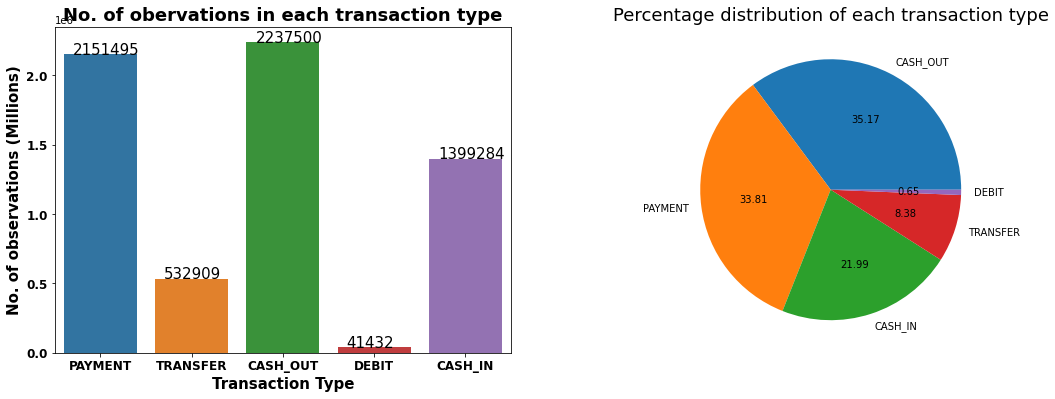

In [102]:
# transaction type
plt.subplots(1,2, figsize=(18,6))

# countplot to visualize the no. of observations under each class
plt.subplot(1,2,1)
ax = sns.countplot(df['type'])
plt.xlabel('Transaction Type', fontsize=15, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel('No. of observations (Millions)', fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('No. of obervations in each transaction type', fontsize=18, fontweight='bold')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.1, i.get_height(), str(round(i.get_height(), 2)), fontsize=15, color='black')

# pie chart to visualize the percentage distribution of each class
plt.subplot(1,2,2)
plt.pie(df['type'].value_counts(), labels=['CASH_OUT','PAYMENT','CASH_IN','TRANSFER','DEBIT'], autopct='%.2f')
plt.title('Percentage distribution of each transaction type', fontsize=18)

# display plot
plt.show()


In [103]:
df['transactionHour'] = df['step'] % 24

# converting into object type
df['transactionHour'] = df['transactionHour'].astype('object')

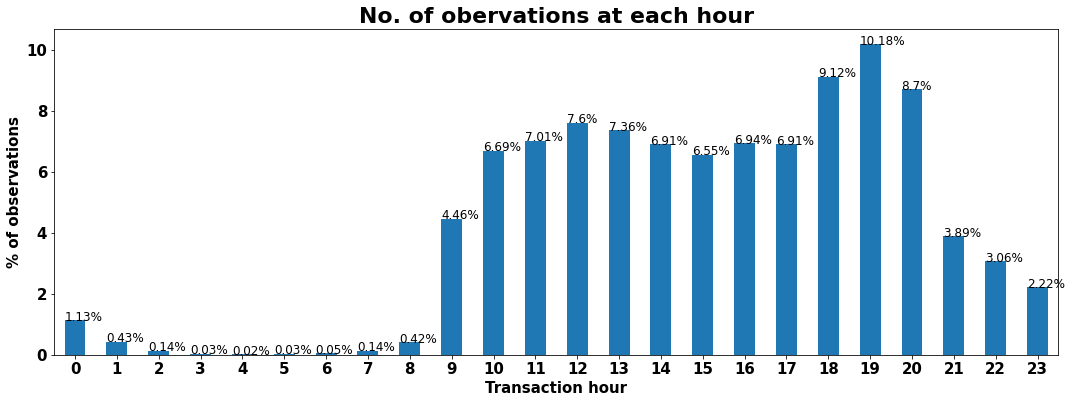

In [104]:
# number of transactions in each hour
plt.figure(figsize=(18,6))
ax = (df['transactionHour'].value_counts(sort=False, normalize=True) * 100).round(2).plot(kind='bar')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)) + "%", fontsize=12, color='black')
plt.xlabel('Transaction hour', fontsize=15, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('% of observations', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('No. of obervations at each hour', fontsize=22, fontweight='bold')
plt.show()

In [105]:
df['transactionBetween'] = df['nameDest'].apply(lambda x: 'Customer2Customer' if x[0] == "C" else 'Customer2Merchant')

In [106]:
df['transactionPeriod'] = df['transactionHour'].apply(lambda x: 'Peak' if x in [2,3,4,5,6] else
                                                                ('Mid' if x in [22,23,0,1,7,8] else 'Safe'))

In [107]:
df['th_amount'] = df['amount'] / 1000

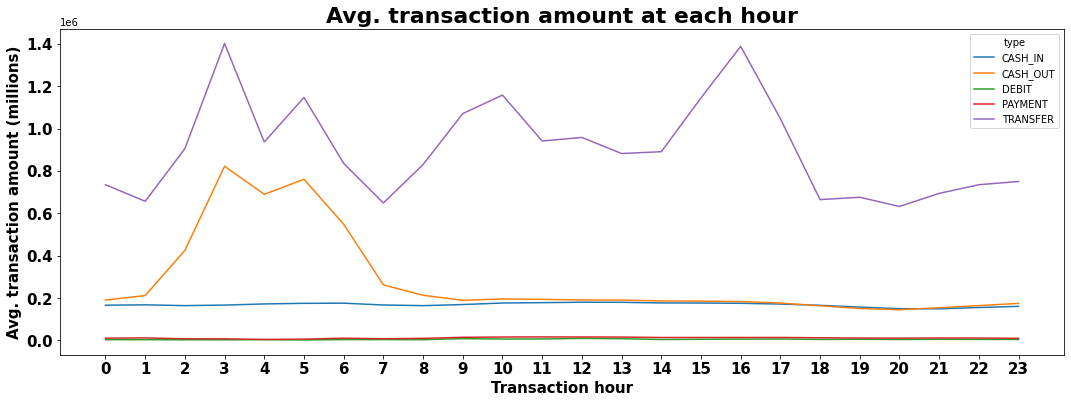

In [108]:
# avg. transaction amount at each hour for each transaction type
plt.figure(figsize=(18,6))
sns.lineplot(data=df.groupby(['transactionHour','type']).agg({'amount' : 'mean'}).round(2).reset_index(),
             x='transactionHour',
             y='amount',
             hue='type')
plt.xlabel('Transaction hour', fontsize=15, fontweight='bold')
plt.xticks(range(24), range(24),fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('Avg. transaction amount (millions)', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Avg. transaction amount at each hour', fontsize=22, fontweight='bold')
plt.show()

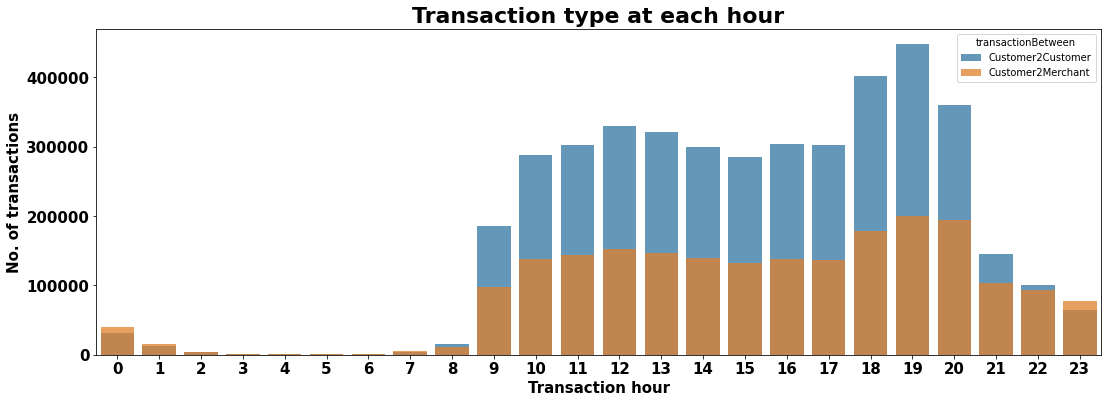

In [109]:
plt.figure(figsize=(18,6))
sns.barplot(data=df.groupby(['transactionHour','transactionBetween']).size().reset_index(),
            x='transactionHour',
            y=0,
            hue='transactionBetween',
            dodge=False,
            alpha=0.75)
plt.xlabel('Transaction hour', fontsize=15, fontweight='bold')
plt.xticks(range(24), range(24),fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('No. of transactions', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Transaction type at each hour', fontsize=22, fontweight='bold')
plt.show()

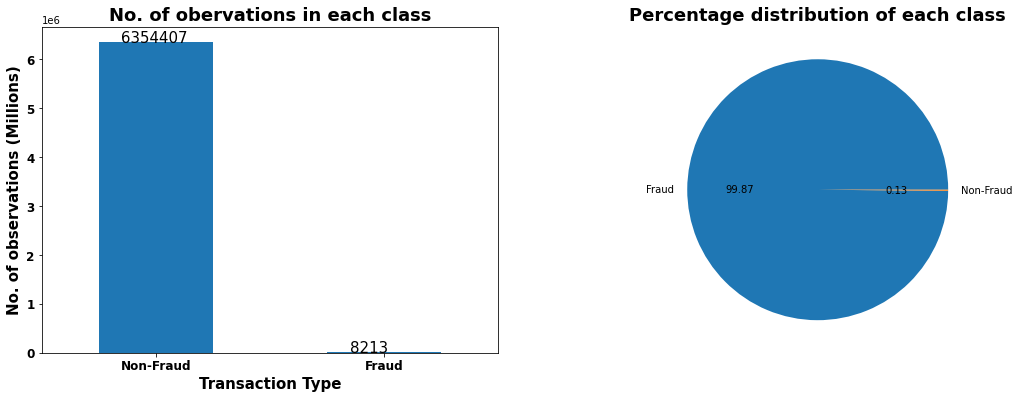

In [110]:
# fraudulent transactions
plt.subplots(1,2, figsize=(18,6))

# countplot to visualize the no. of observations under each class
plt.subplot(1,2,1)
ax = df['isFraud'].value_counts().plot(kind='bar')
plt.xlabel('Transaction Type', fontsize=15, fontweight='bold')
plt.xticks(ticks=[0,1], labels=['Non-Fraud','Fraud'], rotation=0, fontsize=12, fontweight='bold')
plt.ylabel('No. of observations (Millions)', fontsize=15, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('No. of obervations in each class', fontsize=18, fontweight='bold')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.1, i.get_height()+3, str(round(i.get_height(), 2)), fontsize=15, color='black')

# pie chart to visualize the percentage distribution of each class
plt.subplot(1,2,2)
plt.pie(df['isFraud'].value_counts(), labels=['Fraud','Non-Fraud'], autopct='%.2f')
plt.title('Percentage distribution of each class', fontsize=18, fontweight='bold')

# display plot
plt.show()

In [111]:
import plotly.graph_objects as go
from plotly.offline import iplot

x = df['isFraud'].value_counts().index
y = df['isFraud'].value_counts().values

trace2 = go.Bar(
     x=x ,
     y=y,
     marker=dict(
         color=y,
         colorscale = 'Viridis',
         reversescale = True
     ),
     name="Imbalance",    
 )
layout = dict(
     title="Data imbalance - isFraud",
     #width = 900, height = 500,
     xaxis=go.layout.XAxis(
     automargin=True),
     yaxis=dict(
         showgrid=False,
         showline=False,
         showticklabels=True,
 #         domain=[0, 0.85],
     ), 
)
fig1 = go.Figure(data=[trace2], layout=layout)
iplot(fig1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



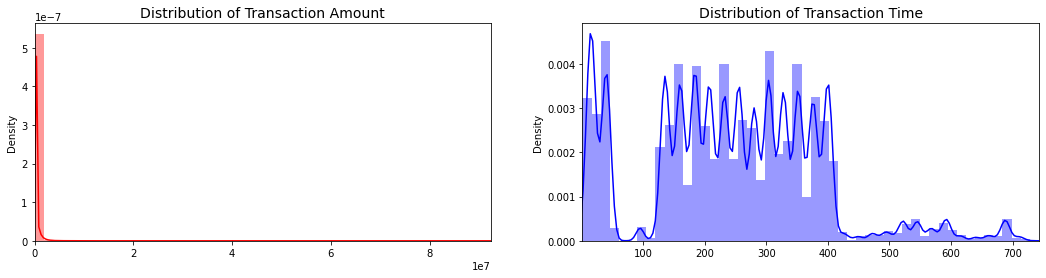

In [112]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['amount'].values
time_val = df['step'].values 

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])


plt.show()

In [113]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [114]:
df['isFraud'].value_counts().values

array([6354407,    8213])

In [115]:
import plotly.graph_objects as go

colors = ['aliceblue', 'antiquewhite'] 


fig = go.Figure(data=[go.Bar(
    x=["0","1"],
    y=df['isFraud'].value_counts().values,
    marker_color=colors 
)])
fig.update_layout(title_text='Data Imbalance isFraud')

In [116]:
import plotly.graph_objects as go

colors = ['blue', 'antiquewhite', 'aqua', 'aquamarine', 'azure'] 


fig = go.Figure(data=[go.Bar(
    x=["CASH-OUT", "PAYMENT", "CASH_IN", "TRANSFERT","DEBIT"],
    y=df['type'].value_counts().values,
    marker_color=colors 
)])
fig.update_layout(title_text='Type')


In [117]:
df_fraud=df[df["isFraud"]==1]


In [118]:
df_nonFraud=df[df["isFraud"]==0]


In [119]:
df_new=pd.concat([df_fraud,df_nonFraud],axis=0)

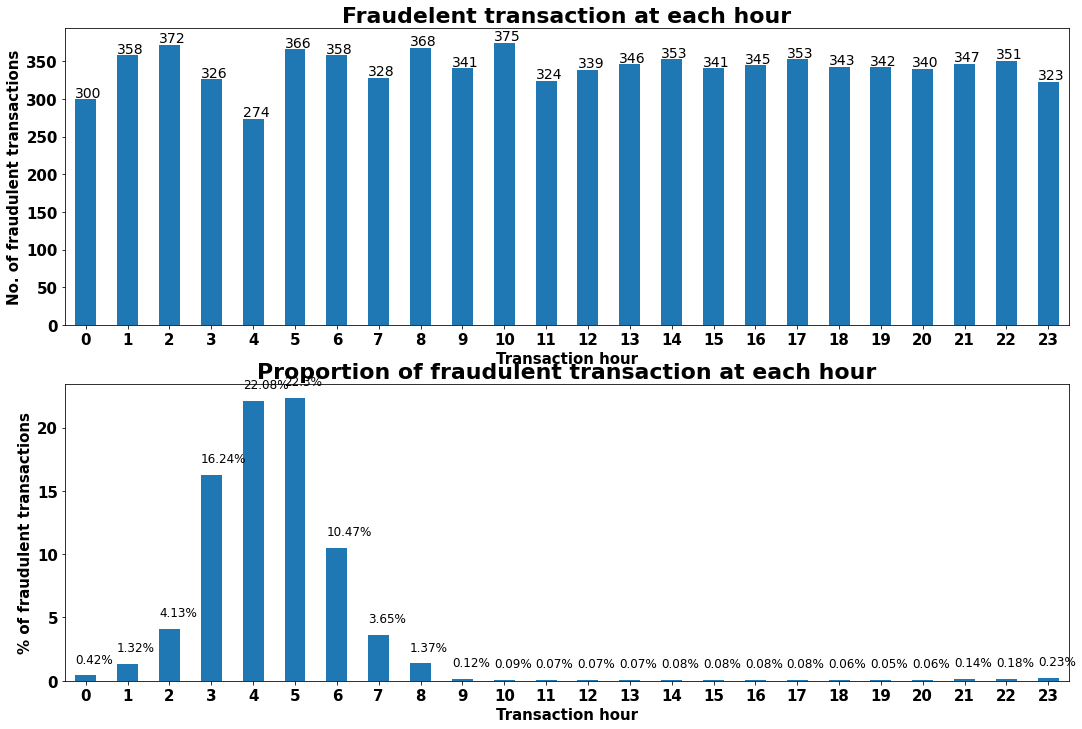

In [120]:
# when does fraud happen? (time of day)
plt.subplots(2,1, figsize=(18,12))

# actual count of fraud cases
plt.subplot(2,1,1)
ax=df_fraud.groupby('transactionHour').size().plot(kind='bar')
plt.xlabel('Transaction hour', fontsize=15, fontweight='bold')
plt.xticks(range(24), range(24),fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('No. of fraudulent transactions', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Fraudelent transaction at each hour', fontsize=22, fontweight='bold')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height()+3, str(round(i.get_height(), 2)), fontsize=14, color='black')
    
# proportion of fraud
plt.subplot(2,1,2)
ax=(df_fraud.groupby('transactionHour').size() / df_new.groupby('transactionHour').size() * 100).plot(kind='bar')
plt.xlabel('Transaction hour', fontsize=15, fontweight='bold')
plt.xticks(range(24), range(24),fontsize=15, fontweight='bold', rotation=0)
plt.ylabel('% of fraudulent transactions', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.title('Proportion of fraudulent transaction at each hour', fontsize=22, fontweight='bold')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height()+1, str(round(i.get_height(), 2))+"%", fontsize=12, color='black')

plt.show()

In [121]:
pd.crosstab(df["type"]=="TRANSFER",df["isFraud"]==1 , normalize=True)\
    .round(5)*100

isFraud,False,True
type,,
False,91.560,0.065
True,8.311,0.064


In [122]:
print('Fraud \n',df.step[df.isFraud==1].describe(),'\n',
      '\n Non-Fraud \n',df.step[df.isFraud==0].describe())

Fraud 
 count    8213.000000
mean      368.413856
std       216.388690
min         1.000000
25%       181.000000
50%       367.000000
75%       558.000000
max       743.000000
Name: step, dtype: float64 
 
 Non-Fraud 
 count    6.354407e+06
mean     2.432357e+02
std      1.421402e+02
min      1.000000e+00
25%      1.560000e+02
50%      2.390000e+02
75%      3.340000e+02
max      7.180000e+02
Name: step, dtype: float64


In [123]:
df=df[0:100000]

In [124]:
df=df.drop(columns="nameDest")

In [125]:
df=df.drop(columns="nameOrig")

In [126]:
df=df.drop(columns="oldbalanceOrg")

In [127]:
df=df.drop(columns="newbalanceOrig")

In [128]:
df=df.drop(columns="oldbalanceDest")
df=df.drop(columns="newbalanceDest")

In [129]:
list_quali = ["transactionBetween"]
df=pd.get_dummies(df,prefix="TOP", columns=list_quali)

In [130]:
list_quali = ["transactionPeriod"]
df=pd.get_dummies(df,prefix="TOP", columns=list_quali)

In [131]:
list_quali = ["type"]
df=pd.get_dummies(df,prefix="TOP", columns=list_quali)

In [132]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, stratify = df["isFraud"])
train, test = train.copy(), test.copy()

In [133]:
features = [i for i in df.columns if i!= "isFraud"]
y = df['isFraud']
X = features

In [134]:
from imblearn.over_sampling import SMOTE



oversample = SMOTE(ratio=0.42)
X_train_smote, y_train_smote = oversample.fit_resample(train[X],train["isFraud"])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [135]:
np.count_nonzero(y_train_smote == 0)
np.count_nonzero(y_train_smote == 1)
v=[np.count_nonzero(y_train_smote == 0),np.count_nonzero(y_train_smote == 1)]
v


[79907, 33560]

In [136]:
import plotly.graph_objects as go

colors = ['aliceblue', 'antiquewhite'] 


fig = go.Figure(data=[go.Bar(
    x=["0","1"],
    y=v,
    marker_color=colors 
)])
fig.update_layout(title_text='Data Imbalance isFraud with smote')

In [137]:
df


,step,amount,isFraud,isFlaggedFraud,transactionHour,th_amount,TOP_Customer2Customer,TOP_Customer2Merchant,TOP_Mid,TOP_Peak,TOP_Safe,TOP_CASH_IN,TOP_CASH_OUT,TOP_DEBIT,TOP_PAYMENT,TOP_TRANSFER
0,1,9839.64,0,0,1,9.83964,0,1,1,0,0,0,0,0,1,0
1,1,1864.28,0,0,1,1.86428,0,1,1,0,0,0,0,0,1,0
2,1,181.00,1,0,1,0.18100,1,0,1,0,0,0,0,0,0,1
3,1,181.00,1,0,1,0.18100,1,0,1,0,0,0,1,0,0,0
4,1,11668.14,0,0,1,11.66814,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,10,4020.66,0,0,10,4.02066,0,1,0,0,1,0,0,0,1,0
99996,10,18345.49,0,0,10,18.34549,0,1,0,0,1,0,0,0,1,0
99997,10,183774.91,0,0,10,183.77491,1,0,0,0,1,1,0,0,0,0
99998,10,82237.17,0,0,10,82.23717,1,0,0,0,1,0,1,0,0,0


In [138]:
pd.Series(y_train_smote).value_counts(normalize=True)

0    0.704231
1    0.295769
dtype: float64

# **KNN classifier sans PCA**


In [139]:
%%time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score
neigh = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 2, weights= 'distance')
neigh.fit(X_train_smote, y_train_smote)
test["y_pred"] = neigh.predict(test[features])
print(accuracy_score(test["isFraud"],test["y_pred"]))
print(precision_score(test["isFraud"],test["y_pred"]))
print(recall_score(test["isFraud"],test["y_pred"]))
print(f1_score(test["isFraud"],test["y_pred"]))
print(confusion_matrix(test["isFraud"],test["y_pred"]))


0.9001
0.009925558312655087
0.8695652173913043
0.019627085377821395
[[17982  1995]
 [    3    20]]
CPU times: user 824 ms, sys: 7.84 ms, total: 832 ms
Wall time: 837 ms


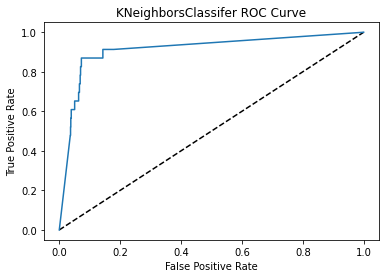

In [140]:
from sklearn.metrics import roc_curve
y_pred_prob=neigh.predict_proba(test[features])[:,1]
fpr, tpr, thresholds = roc_curve(test["isFraud"], y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='KNeighborsClassifer')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNeighborsClassifer ROC Curve')
plt.show()

In [141]:
from sklearn.metrics import roc_auc_score

y_pred = neigh.predict_proba(test[features])[:,1]
roc_auc_score(test["isFraud"], y_pred)

0.9119302415168749

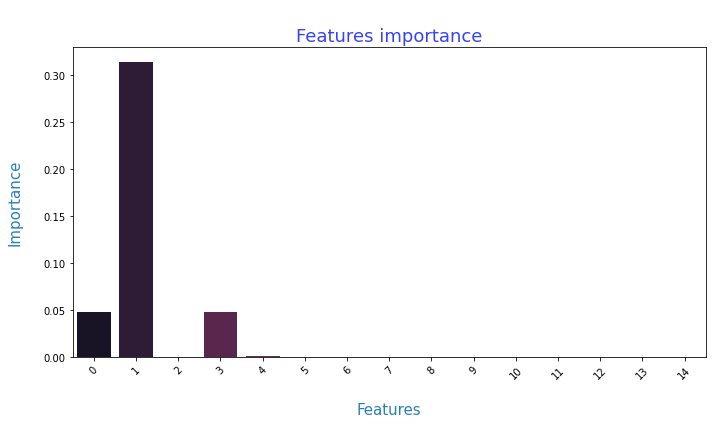

In [142]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
results = permutation_importance(neigh, X_train_smote, y_train_smote, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
plt.figure(figsize=(10,6))
sns.barplot(x=[x for x in range(len(importance))], y=importance, palette="rocket")
plt.xlabel('\nFeatures', fontsize=15, color='#2980b9')
plt.ylabel("Importance\n", fontsize=15, color='#2980b9')
plt.title("\nFeatures importance", fontsize=18, color='#3742fa')
plt.xticks(rotation= 45)
plt.tight_layout()

# **Decision tree sans PCA**

In [143]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score

dtc = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

dtc.fit(X_train_smote, y_train_smote)

test["y_pred"] = dtc.predict(test[features])

print(accuracy_score(test["isFraud"],test["y_pred"]))
print(precision_score(test["isFraud"],test["y_pred"]))
print(recall_score(test["isFraud"],test["y_pred"]))
print(f1_score(test["isFraud"],test["y_pred"]))

0.9976
0.1794871794871795
0.30434782608695654
0.22580645161290322
CPU times: user 442 ms, sys: 6 µs, total: 442 ms
Wall time: 444 ms


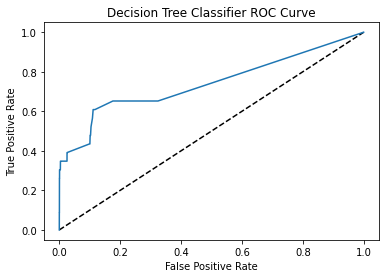

In [144]:
from sklearn.metrics import roc_curve
y_pred_prob=dtc.predict_proba(test[features])[:,1]
fpr, tpr, thresholds = roc_curve(test["isFraud"], y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Decision Tree Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Classifier ROC Curve')
plt.show()


In [145]:
from sklearn.metrics import roc_auc_score

y_pred = dtc.predict_proba(test[features])[:,1]
roc_auc_score(test["isFraud"], y_pred_prob)

0.7409216250862405

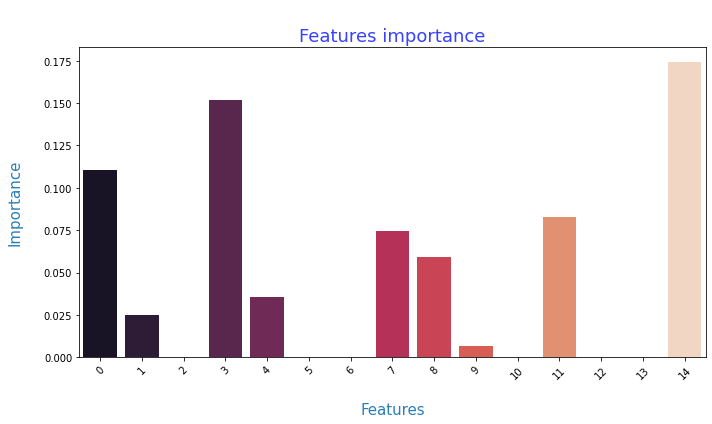

In [146]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
results = permutation_importance(dtc, X_train_smote, y_train_smote, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
plt.figure(figsize=(10,6))
sns.barplot(x=[x for x in range(len(importance))], y=importance, palette="rocket")
plt.xlabel('\nFeatures', fontsize=15, color='#2980b9')
plt.ylabel("Importance\n", fontsize=15, color='#2980b9')
plt.title("\nFeatures importance", fontsize=18, color='#3742fa')
plt.xticks(rotation= 45)
plt.tight_layout()

# **Random forest sans PCA**

In [147]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from sklearn.metrics import accuracy_score,precision_score, recall_score

clf=RandomForestClassifier(n_estimators=20,n_jobs=-1,max_depth=70)

clf.fit(X_train_smote, y_train_smote)
test["y_pred"] = clf.predict(test[features])
print(accuracy_score(test["isFraud"],test["y_pred"]))
print(precision_score(test["isFraud"],test["y_pred"]))
print(recall_score(test["isFraud"],test["y_pred"]))
print(f1_score(test["isFraud"],test["y_pred"]))

0.9953
0.06172839506172839
0.21739130434782608
0.09615384615384615
CPU times: user 2.67 s, sys: 32.1 ms, total: 2.7 s
Wall time: 1.56 s


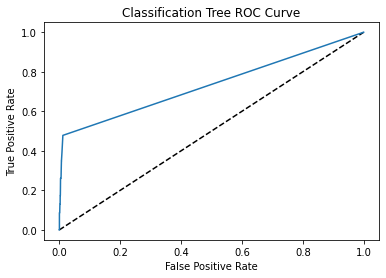

In [148]:
from sklearn.metrics import roc_curve
y_pred_prob=clf.predict_proba(test[features])[:,1]
fpr, tpr, thresholds = roc_curve(test["isFraud"], y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Classification Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification Tree ROC Curve')
plt.show()

In [149]:
from sklearn.metrics import roc_auc_score

y_pred = clf.predict_proba(test[features])[:,1]
roc_auc_score(test["isFraud"], y_pred_prob)

0.7337078945134731

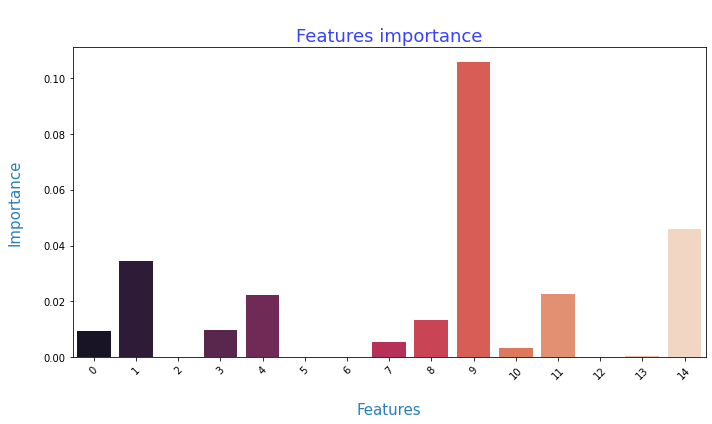

In [150]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
results = permutation_importance(clf, X_train_smote, y_train_smote, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
plt.figure(figsize=(10,6))
sns.barplot(x=[x for x in range(len(importance))], y=importance, palette="rocket")
plt.xlabel('\nFeatures', fontsize=15, color='#2980b9')
plt.ylabel("Importance\n", fontsize=15, color='#2980b9')
plt.title("\nFeatures importance", fontsize=18, color='#3742fa')
plt.xticks(rotation= 45)
plt.tight_layout()

# **Logistic regression sans PCA**

In [151]:
%%time
from sklearn.linear_model import LogisticRegression
import pickle

logreg=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logreg.fit(X_train_smote, y_train_smote)




y_pred=logreg.predict(test[features])
print(confusion_matrix(test["isFraud"],test["y_pred"]))
print(classification_report(test["isFraud"],test["y_pred"]))
print(accuracy_score(test["isFraud"],test["y_pred"]))
print(precision_score(test["isFraud"],test["y_pred"]))
print(recall_score(test["isFraud"],test["y_pred"]))
print(f1_score(test["isFraud"],test["y_pred"]))



[[19901    76]
 [   18     5]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19977
           1       0.06      0.22      0.10        23

    accuracy                           1.00     20000
   macro avg       0.53      0.61      0.55     20000
weighted avg       1.00      1.00      1.00     20000

0.9953
0.06172839506172839
0.21739130434782608
0.09615384615384615
CPU times: user 346 ms, sys: 234 ms, total: 580 ms
Wall time: 300 ms


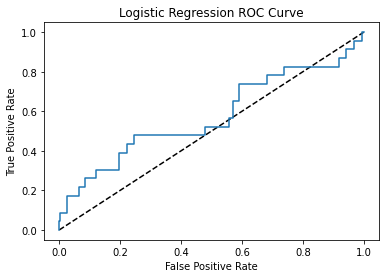

In [152]:
from sklearn.metrics import roc_curve
y_pred_prob=logreg.predict_proba(test[features])[:,1]
fpr, tpr, thresholds = roc_curve(test["isFraud"], y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [153]:
from sklearn.metrics import roc_auc_score

y_pred = logreg.predict_proba(test[features])[:,1]
roc_auc_score(test["isFraud"], y_pred_prob)

0.5746848005641271

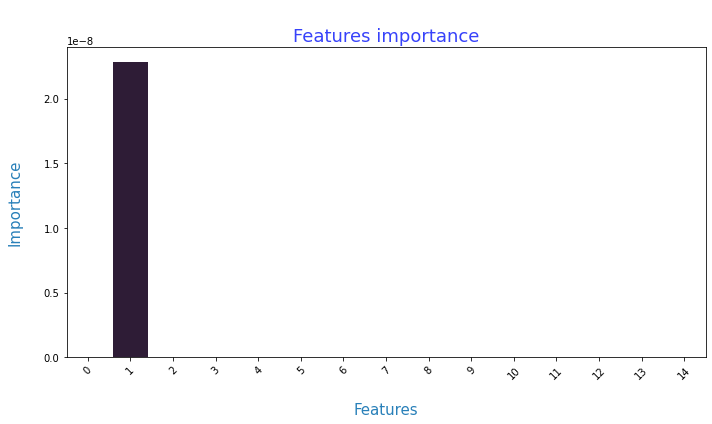

In [154]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
results = permutation_importance(logreg, X_train_smote, y_train_smote, scoring='neg_mean_squared_error')
# get importance
importance = logreg.coef_[0]
plt.figure(figsize=(10,6))
sns.barplot(x=[x for x in range(len(importance))], y=importance, palette="rocket")
plt.xlabel('\nFeatures', fontsize=15, color='#2980b9')
plt.ylabel("Importance\n", fontsize=15, color='#2980b9')
plt.title("\nFeatures importance", fontsize=18, color='#3742fa')
plt.xticks(rotation= 45)
plt.tight_layout()

# ROC CURVE MÊME GRAPHE

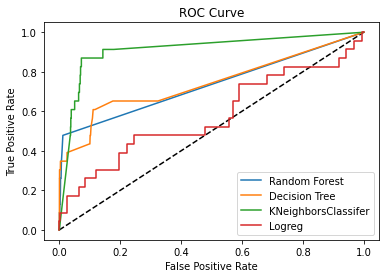

In [158]:
from sklearn.metrics import roc_curve
y_pred_prob=clf.predict_proba(test[features])[:,1]
y_pred_prob1=dtc.predict_proba(test[features])[:,1]
y_pred_prob2=neigh.predict_proba(test[features])[:,1]
y_pred_prob_logreg=logreg.predict_proba(test[features])[:,1]
fpr, tpr, thresholds = roc_curve(test["isFraud"], y_pred_prob)
fpr1, tpr1, thresholds1 = roc_curve(test["isFraud"], y_pred_prob1)
fpr2, tpr2, thresholds2 = roc_curve(test["isFraud"], y_pred_prob2)
fpr3, tpr3, thresholds3 = roc_curve(test["isFraud"], y_pred_prob_logreg)


plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Random Forest')
plt.plot(fpr1, tpr1, label='Decision Tree')
plt.plot(fpr2, tpr2, label='KNeighborsClassifer')
plt.plot(fpr3, tpr3, label='Logreg')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

# Standart scaler

In [159]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train_smote)
# Apply transform to both the training set and the test set.
X_train_scaled = scaler.transform(X_train_smote)
X_test_scaled =scaler.transform(test[X])

#PCA

In [160]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.90)

pca.fit(X_train_scaled)

X_train_smote_pca = pca.transform(X_train_scaled)
X_test_pca =pca.transform(X_test_scaled)

In [161]:
pca.explained_variance_ratio_

array([0.28613313, 0.2171499 , 0.14043361, 0.09775052, 0.09002087,
       0.07194191])

In [162]:
X_train_smote_pca

array([[ 0.03439512, -1.70300253,  0.53792378,  0.02074523, -1.16234191,
         0.15039685],
       [-3.41871692,  0.25798145,  0.71486645, -0.61380525, -0.25723323,
         0.05052625],
       [ 1.01957813, -0.01407255, -1.20151302,  0.6138735 ,  2.03131906,
        -0.0890192 ],
       ...,
       [ 2.81135875,  1.54575331, -0.28794447, -1.5336974 , -1.40248457,
        -0.17765489],
       [ 1.24064602,  0.39102708, -1.46751658,  0.54068796,  1.90431549,
        -0.10835259],
       [ 1.4160312 ,  0.73963653, -0.49370814,  1.24229375,  0.42440582,
        -0.01235192]])

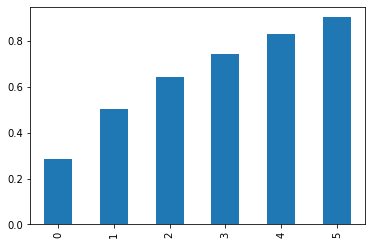

In [163]:
pd.Series(pca.explained_variance_ratio_).cumsum().plot.bar()

In [164]:
train["isFraud"].sum()

93

# **K NEIGHBORS CLASSIFIER**

In [165]:
%%time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score
neigh = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 1, weights= 'distance')
neigh.fit(X_train_smote_pca, y_train_smote)
test["y_pred"] = neigh.predict(X_test_pca)
print(accuracy_score(test["isFraud"],test["y_pred"]))
print(precision_score(test["isFraud"],test["y_pred"]))
print(recall_score(test["isFraud"],test["y_pred"]))
print(f1_score(test["isFraud"],test["y_pred"]))
print(confusion_matrix(test["isFraud"],test["y_pred"]))


0.9952
0.08045977011494253
0.30434782608695654
0.12727272727272726
[[19897    80]
 [   16     7]]
CPU times: user 303 ms, sys: 5.92 ms, total: 309 ms
Wall time: 308 ms


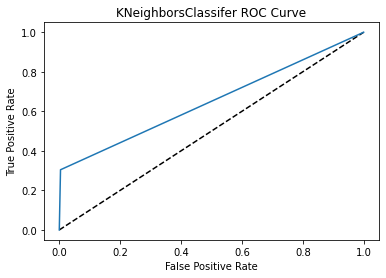

In [166]:
from sklearn.metrics import roc_curve
y_pred_prob=neigh.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(test["isFraud"], y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='KNeighborsClassifer')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNeighborsClassifer ROC Curve')
plt.show()



In [167]:
from sklearn.metrics import roc_auc_score

y_pred = neigh.predict_proba(X_test_pca)[:,1]
roc_auc_score(test["isFraud"], y_pred_prob)

0.650171610395433

# **DECISION TREE CLASSIFIER**

In [168]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

dtc = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

dtc.fit(X_train_smote_pca, y_train_smote)

test["y_pred"] = dtc.predict(X_test_pca)
print(accuracy_score(test["isFraud"],test["y_pred"]))
print(precision_score(test["isFraud"],test["y_pred"]))
print(recall_score(test["isFraud"],test["y_pred"]))
print(f1_score(test["isFraud"],test["y_pred"]))

0.98665
0.04477611940298507
0.5217391304347826
0.08247422680412371
CPU times: user 784 ms, sys: 2.96 ms, total: 787 ms
Wall time: 788 ms


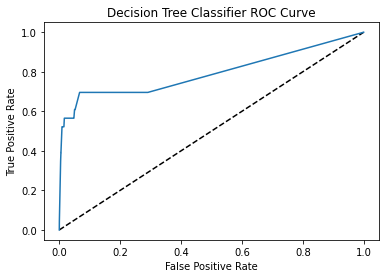

In [169]:
from sklearn.metrics import roc_curve
y_pred_prob=dtc.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(test["isFraud"], y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Decision Tree Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Classifier ROC Curve')
plt.show()


In [170]:
from sklearn.metrics import roc_auc_score

y_pred = dtc.predict_proba(X_test_pca)[:,1]
roc_auc_score(test["isFraud"], y_pred_prob)

0.7937171225169816

# **RANDOM FOREST CLASSIFIER**

In [171]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from sklearn.metrics import accuracy_score,precision_score, recall_score

clf=RandomForestClassifier(n_estimators=20,n_jobs=-1,max_depth=70)

clf.fit(X_train_smote_pca, y_train_smote)
test["y_pred"] = clf.predict(X_test_pca)
print(accuracy_score(test["isFraud"],test["y_pred"]))
print(precision_score(test["isFraud"],test["y_pred"]))
print(recall_score(test["isFraud"],test["y_pred"]))
print(f1_score(test["isFraud"],test["y_pred"]))

0.9948
0.08247422680412371
0.34782608695652173
0.13333333333333333
CPU times: user 6.47 s, sys: 26.3 ms, total: 6.5 s
Wall time: 3.55 s


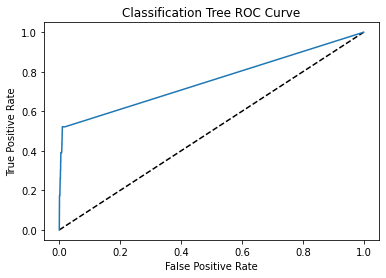

In [172]:
from sklearn.metrics import roc_curve
y_pred_prob=clf.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(test["isFraud"], y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Classification Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification Tree ROC Curve')
plt.show()

In [173]:
from sklearn.metrics import roc_auc_score

y_pred = clf.predict_proba(X_test_pca)[:,1]
roc_auc_score(test["isFraud"], y_pred_prob)

0.75428373063806

# **LOGISTIC REGRESSION**

In [174]:
%%time
from sklearn.linear_model import LogisticRegression
import pickle

logreg=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logreg.fit(X_train_smote_pca, y_train_smote)
'''
# On utilise pickle
filename_logreg = 'finalized_model.sav'
pickle.dump(logreg, open(filename, 'wb'))'''


y_pred=logreg.predict(X_test_pca)
print(confusion_matrix(test["isFraud"],test["y_pred"]))
print(classification_report(test["isFraud"],test["y_pred"]))
print(accuracy_score(test["isFraud"],test["y_pred"]))
print(precision_score(test["isFraud"],test["y_pred"]))
print(recall_score(test["isFraud"],test["y_pred"]))
print(f1_score(test["isFraud"],test["y_pred"]))
'''
# On load
loaded_model = pickle.load(open(filename_logreg, 'rb'))
result = loaded_model.score(X_test_pca, test["y_pred"])
print("pickle :" + result)'''

[[19888    89]
 [   15     8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19977
           1       0.08      0.35      0.13        23

    accuracy                           0.99     20000
   macro avg       0.54      0.67      0.57     20000
weighted avg       1.00      0.99      1.00     20000

0.9948
0.08247422680412371
0.34782608695652173
0.13333333333333333
CPU times: user 383 ms, sys: 303 ms, total: 686 ms
Wall time: 373 ms


In [175]:
# save the model to disk

import pickle

filename = 'finalized_model.sav'
pickle.dump(logreg, open(filename, 'wb'))


loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_pca, test["y_pred"])
print(result)

0.95955


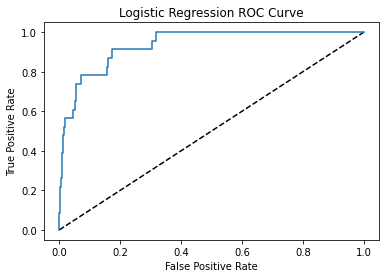

In [176]:
from sklearn.metrics import roc_curve
y_pred_prob_logreg=logreg.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(test["isFraud"], y_pred_prob_logreg)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()


In [177]:
from sklearn.metrics import roc_auc_score

y_pred = logreg.predict_proba(X_test_pca)[:,1]
roc_auc_score(test["isFraud"], y_pred_prob_logreg)

0.9352646848223283

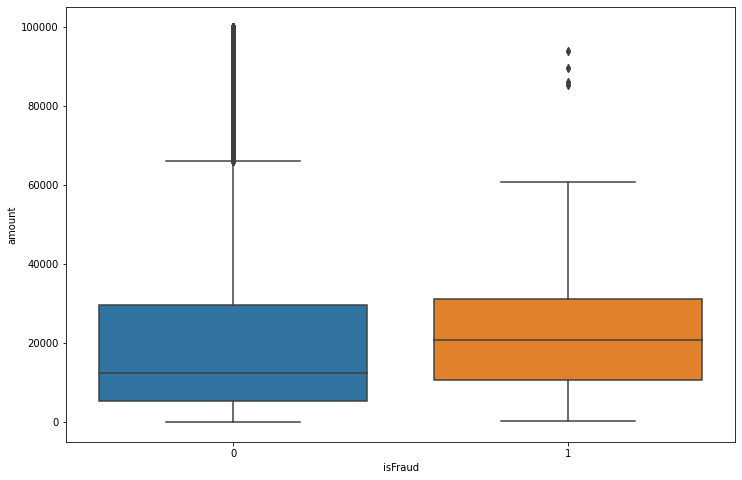

In [178]:
plt.figure(figsize=(12,8))
sns.boxplot(x = 'isFraud', y = 'amount', data = df[df.amount < 1e5])

In [179]:
%%time
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 15)}

knn_cv = GridSearchCV(neigh, param_grid, cv=3)
knn_cv.fit(X_train_smote_pca, y_train_smote)
knn_cv.best_params_

CPU times: user 14.2 s, sys: 66.6 ms, total: 14.3 s
Wall time: 14.2 s


In [180]:
knn_cv.best_params_

{'n_neighbors': 2}

# **Feature importance RandomForest**

Feature: 0, Score: 0.37333
Feature: 1, Score: 0.15137
Feature: 2, Score: 0.05100
Feature: 3, Score: 0.19969
Feature: 4, Score: 0.09110
Feature: 5, Score: 0.13352


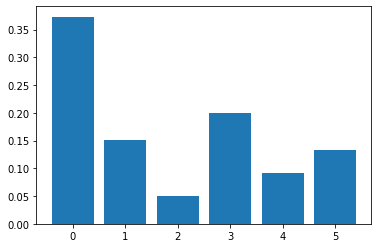

In [181]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# **Feature Importance DecisionTree**

Feature: 0, Score: 0.57020
Feature: 1, Score: 0.08298
Feature: 2, Score: 0.03226
Feature: 3, Score: 0.14743
Feature: 4, Score: 0.04292
Feature: 5, Score: 0.12422


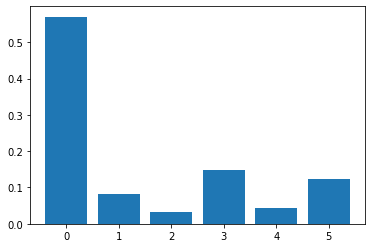

In [182]:
import matplotlib.pyplot as plt
importance = dtc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# **Feature Importance Logistic Regression**

Feature: 0, Score: 1.86407
Feature: 1, Score: -0.12470
Feature: 2, Score: -0.07059
Feature: 3, Score: -0.69642
Feature: 4, Score: -0.15912
Feature: 5, Score: -0.25675


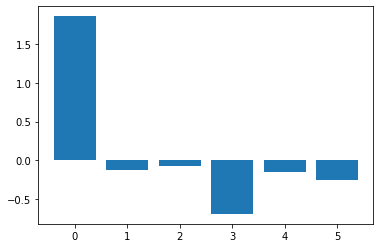

In [183]:
import matplotlib.pyplot as plt
importance = logreg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# **Feature Importance KNeighbors**

Feature: 0, Score: 0.41208
Feature: 1, Score: 0.32255
Feature: 2, Score: 0.17674
Feature: 3, Score: 0.31789
Feature: 4, Score: 0.27031
Feature: 5, Score: 0.01862


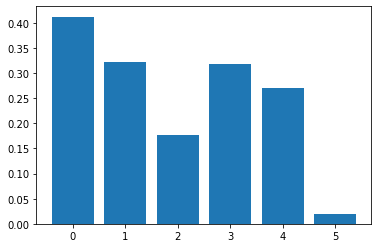

In [184]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
results = permutation_importance(neigh, X_train_smote_pca, y_train_smote, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [185]:
from sklearn.model_selection import GridSearchCV
grid_params={
    'n_neighbors':np.arange(1, 15),
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']

}
gs=GridSearchCV(
   KNeighborsClassifier(),
   grid_params,
   verbose=1,
   cv=3,
   n_jobs=-1
)
gs_results=gs.fit(X_train_smote_pca,y_train_smote)

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:  2.1min finished


In [186]:
gs_results.best_params_




{'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}

In [187]:
from sklearn.model_selection import GridSearchCV
rfc=RandomForestClassifier(random_state=42)
param_grid={
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']

}
gs2=GridSearchCV(
   estimator=rfc,
    param_grid=param_grid, 
    cv= 5
)
gs_results2=gs2.fit(X_train_smote_pca,y_train_smote)

KeyboardInterrupt: ignored

In [ ]:
from sklearn.model_selection import GridSearchCV
dtc
param_dict={
    'criterion':['gini','entropy'],
    'max_depth':range(1,10),
    'min_samples_split':range(1,10),
    'min_samples_leaf':range(1,5)
}
grid=GridSearchCV(
    dtc,
    param_grid=param_dict,
    cv=10,
    verbose=1,
    n_jobs=-1
)
gs_results3=grid.fit(X_train_smote_pca,y_train_smote)

In [ ]:
gs_results3.best_estimator_

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid1 = {'penalty': ['l1', 'l2'],
               'C' : np.arange(0.001, 25)}
    


# Create grid search object

grid3 = GridSearchCV(logreg,param_grid = param_grid1, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = grid3.fit(X_train_smote_pca, y_train_smote)
LogisticRegression()

In [ ]:
param_grid = [

{'classifier' : [LogisticRegression()],

'classifier__penalty' : ['l1', 'l2'],

'classifier__C' : np.logspace(-4, 4, 20),

'classifier__solver' : ['liblinear']},

]



# Create grid search object



clf = GridSearchCV(logreg, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)



# Fit on data



best_clf = clf.fit(X_train_smote_pca, y_train_smote)

In [ ]:
estimator.get_params().keys()

In [ ]:
from sklearn.model_selection import GridSearchCV
grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}
logreg_cv=GridSearchCV(logreg,grid,cv=10)
best_log = logreg_cv.fit(X_train_smote_pca, y_train_smote)

In [ ]:
best_log.best_params_

# ROC CURVE MEME GRAPHE

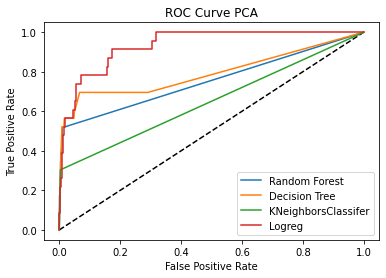

In [188]:
from sklearn.metrics import roc_curve
y_pred_prob=clf.predict_proba(X_test_pca)[:,1]
y_pred_prob1=dtc.predict_proba(X_test_pca)[:,1]
y_pred_prob2=neigh.predict_proba(X_test_pca)[:,1]
y_pred_prob_logreg=logreg.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(test["isFraud"], y_pred_prob)
fpr1, tpr1, thresholds1 = roc_curve(test["isFraud"], y_pred_prob1)
fpr2, tpr2, thresholds2 = roc_curve(test["isFraud"], y_pred_prob2)
fpr3, tpr3, thresholds3 = roc_curve(test["isFraud"], y_pred_prob_logreg)


plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Random Forest')
plt.plot(fpr1, tpr1, label='Decision Tree')
plt.plot(fpr2, tpr2, label='KNeighborsClassifer')
plt.plot(fpr3, tpr3, label='Logreg')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve PCA')
plt.show()